In [1]:
import pickle
import string
from abc import ABC, abstractmethod

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FixedLocator
from sklearn.metrics import roc_curve

from gauss_mix import generate_gauss_mix

In [2]:
sns.set(color_codes=True, style="ticks", context="talk", font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)

In [3]:
COMMON_CLFS = {
    "MIGHT" : {"color" : "#e41a1c", "lw" : 3},
    "RF" : {"color" : "#377eb8"},
    "SVM" : {"color" : "#4daf4a"},
    "LR" : {"color" : "#ff7f00"},
    "KNN" : {"color" : "#a65628"},
}

ALL_CLFS = {
    "S@98" : COMMON_CLFS,
    "Mutual Information" : dict(COMMON_CLFS, KSG={"color" : "#f781bf"}),
    "AUC" : COMMON_CLFS,
    "Power" : dict(COMMON_CLFS, Dcorr={"color" : "#984ea3"})
}

FILE_METRICS = {
    "S@98": "S98",
    "Mutual Information" : "MI",
    "AUC" : "AUC",
    "Power" : "power"
}

COLUMN_ORDER = [
    "S@98",
    "AUC",
    # "Mutual Information",
    "Power"
]

In [56]:
class PlotFigures(ABC):
    def __init__(self, simulation_name, simulation_kwargs=None, roc_iterations=100, truths=None, simulation_ticks=[-3, 0, 3]):
        self.simulation_name = simulation_name
        self.simulation_kwargs = simulation_kwargs
        self.roc_iterations = roc_iterations
        self.truths = truths
        self.simulation_ticks = simulation_ticks

    def plot_figure(self):
        # define figure attributes
        fig = plt.figure(figsize=(16, 18), constrained_layout=True)
        self.ncols = 3
        subfigs = fig.subfigures(3, 1, hspace=0.1)
        subfigs_top = subfigs[0].subfigures(1, 2, width_ratios=[2, 1], wspace=0.1)
        subfigs_top_pad = subfigs_top[0].subfigures(1, 2, width_ratios=[1, 13])
        axs_sims = subfigs_top_pad[1].subplots(1, 2)
        axs_roc = subfigs_top[1].subplots(1, 1)
        axs_inc_n = subfigs[1].subplots(1, 3)
        axs_inc_d = subfigs[2].subplots(1, 3)
        self.axes = [*axs_sims, axs_roc, *axs_inc_n, *axs_inc_d]
        
        self.plot_simulations()
        self.plot_roc()
        self.plot_metrics_power()

        # misc section titles
        subfigs_top_pad[1].suptitle(f"{self.simulation_name.capitalize()} simulation up to 4096 variables")
        axs_roc.set_title("ROC curve for 256 samples and\n4096 variables", fontsize='large')
        subfigs[1].suptitle("Statistical estimates for 4096 variables")
        subfigs[2].suptitle("Statistical estimates for 256 samples")

        # add lettering
        for i, ax in enumerate(self.axes):
            ax.set_title(
                string.ascii_uppercase[i], loc="left", weight="bold"
            )
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        # add legends
        leg_sims = fig.legend(
            *self.axes[1].get_legend_handles_labels(),
            loc="upper left",
            ncol=1,
            bbox_to_anchor=(0.17, 0.98),
            fontsize=20,
        )
        leg_roc = fig.legend(
            handles=self.axes[2].get_legend_handles_labels()[0] + [self.axes[5].get_legend_handles_labels()[0][-1]],
            labels=self.axes[2].get_legend_handles_labels()[1] + [self.axes[5].get_legend_handles_labels()[1][-1]],
            *self.axes[2].get_legend_handles_labels(),
            loc="lower center",
            ncol=len(self.axes[2].get_legend_handles_labels()[1]) + 1,
            bbox_to_anchor=(0.5, -0.1),
            # columnspacing=4.0
        )
        # leg_mi = fig.legend(
        #     handles=[self.axes[6].get_legend_handles_labels()[0][-1]],
        #     labels=[self.axes[6].get_legend_handles_labels()[1][-1]],
        #     loc="lower center",
        #     ncol=1,
        #     bbox_to_anchor=(0.741, -0.13)
        # )
        # leg_power = fig.legend(
        #     handles=[self.axes[5].get_legend_handles_labels()[0][-1]],
        #     labels=[self.axes[5].get_legend_handles_labels()[1][-1]],
        #     loc="lower center",
        #     ncol=1,
        #     bbox_to_anchor=(0.873, -0.16)
        # )
        # for leg in [leg_sims, leg_roc, leg_mi, leg_power]:
        for leg in [leg_sims, leg_roc]:
            leg.get_frame().set_linewidth(0)
            for legobj in leg.legend_handles:
                legobj.set_linewidth(5.0)

        plt.savefig(f"figs/might_{self.simulation_name}.pdf", transparent=True, bbox_inches='tight')
        plt.show()

    def plot_simulations(self, n=50):
        pdf = self._generate_data(n, **self.simulation_kwargs)[-1]
        pdf_noise = self._generate_data(n, mu_class1=0)[-1]

        for i, plot_pdf in enumerate([pdf, pdf_noise]):
            sns.lineplot(
                plot_pdf, x="x", y="pdf_class0", color="black", ax=self.axes[i], label="Control", legend=False, lw=5
            )
            sns.lineplot(
                plot_pdf, x="x", y="pdf_class1", color="#969696", ax=self.axes[i], label="Case", linestyle="--", legend=False
            )

        # make plot look pretty
        self.axes[0].set(
            xlabel="Variable 1",
            ylabel="Distribution",
            xticks=self.simulation_ticks,
            yticks=[],
            ylim=[0, 0.5]
        )
        self.axes[1].set(
            xlabel="Variables 2 to 4096",
            ylabel="",
            xticks=[-3, 0, 3],
            yticks=[],
            ylim=[0, 0.5]
        )

        # simulated_df = pd.DataFrame(dict(x=x.ravel(), x_noise=x_noise.ravel(), hue=np.tile([0, 1], n // 2)))
        # sns.scatterplot(simulated_df, x="x", y="x_noise", hue="hue", ax=self.axes[2], palette=["black", "#969696"], legend=False)

        # # make plot look pretty
        # self.axes[2].set(
        #     xlabel="Variable 1",
        #     ylabel="Other Variables",
        #     xticks=self.simulation_ticks,
        #     yticks=[-3, 0, 3]
        # )

    @staticmethod
    def _generate_data(n=256, **kwargs):
        return generate_gauss_mix(
            N=n,
            **kwargs,
        )

    def plot_roc(self):
        # compute true fpr, tpr, and thresholds and plot the ROC
        x, y, posterior, *_ = self._generate_data(n=50000, **self.simulation_kwargs)
        true_fpr, true_tpr, true_thresholds = roc_curve(
            y, posterior, pos_label=1, drop_intermediate=False
        )
        # self.axes[2].plot([0, 1], [0, 1], linestyle="--", color="black", alpha=0.5),
        self.axes[2].plot(true_fpr, true_tpr, label="Truth", color="black")
        
        # load all other classifier ROC data and plot ROC curves
        base_fpr = np.linspace(0, 1, 1001)
        for clf_name, plot_kwargs in COMMON_CLFS.items():
            try:
                with open(f"fig1_v2_results/fpr_{self.simulation_name}_{clf_name}.pkl", "rb") as f:
                    clf_fpr = pickle.load(f)
            except FileNotFoundError:
                print(f"fig1_v2_results/fpr_{self.simulation_name}_{clf_name}.pkl is missing")
                continue
            try:
                with open(f"fig1_v2_results/tpr_{self.simulation_name}_{clf_name}.pkl", "rb") as f:
                    clf_tpr = pickle.load(f)
            except FileNotFoundError:
                print(f"fig1_v2_results/tpr_{simulation_name}_{clf_name}.pkl is missing")
                continue
            clf_tprs = []
            for i in range(self.roc_iterations):
                try:
                    clf_tprs.append(np.interp(base_fpr, clf_fpr[i], clf_tpr[i]))
                except IndexError:
                    break
            mean_clf_tpr = np.mean(clf_tprs, axis=0)
            self.axes[2].plot(base_fpr, mean_clf_tpr, **plot_kwargs, label=clf_name)

        # make plot look pretty
        self.axes[2].set(
            xlabel="False Positive Rate",
            ylabel="True Positive Rate",
            xticks=[0, 1],
            yticks=[0, 1],
            xlim=[0, 1],
            ylim=[0, 1]
        )

    def plot_metrics_power(self):
        for i, ax in enumerate(self.axes[self.ncols:]):
            c = i % self.ncols
            metric = COLUMN_ORDER[c]
            if metric != "Power":
            #     ax.axhline(
            #         y=0.05,
            #         linestyle=":",
            #         color="black",
            #         label="Alpha",
            #     )
            # else:
                ax.axhline(
                    y=self.truths[metric],
                    color="black",
                )

            if i // self.ncols == 0:
                xs = [128, 256, 512, 1024]#, 2048, 4096]
                n_or_d = "n"
            else:
                xs = [2**i for i in range(2, 13)]
                n_or_d = "d"
            for i, (test, plot_kwargs) in enumerate(ALL_CLFS[metric].items()):
                file_test = test if test != "MIGHT" else test.lower()
                if metric == "Power" and test == "MIGHT":
                    file_test += "-S98"
                try:
                    ys = np.genfromtxt(
                        f"results/{self.simulation_name}-{file_test}-{FILE_METRICS[metric]}-vs-{n_or_d}.csv", delimiter=","
                    )
                except FileNotFoundError:
                    print(f"results/{self.simulation_name}-{file_test}-{FILE_METRICS[metric]}-vs-{n_or_d}.csv is missing")
                    continue
                if metric == "Power":
                    ys = np.array([y if y > 0 else 0 for y in ys])
                    ys = ys[1:-2] if n_or_d == "n" else ys
                    if len(xs) != ys.size:
                        point_to_nan = len(xs) - ys.size
                        ys = np.concatenate([np.tile(np.nan, point_to_nan), ys])
                    if test == "Dcorr_PCA":
                        test = "Dcorr-PCA"
                    ax.plot(xs, ys, **plot_kwargs, label=test)
                else:
                    quantiles = []
                    for quantile in [0.25, 0.5, 0.75]:
                        quartile = np.quantile(ys, quantile, axis=1)
                        quartile = np.array([y if y > 0 else 0 for y in quartile])
                        quartile = quartile[:-2] if n_or_d == "n" else quartile
                        if test == "MIGHT" and n_or_d == "n":
                            quartile = quartile[1:]
                        if len(xs) != quartile.size:
                            point_to_nan = len(xs) - quartile.size
                            quartile = np.concatenate([np.tile(np.nan, point_to_nan), quartile])
                        quantiles.append(quartile)
                    ax.plot(xs, quantiles[1], **plot_kwargs, label=test)
                    ax.fill_between(
                        xs,
                        quantiles[0],
                        quantiles[2],
                        alpha=0.2,
                        color=plot_kwargs["color"],
                    )
        
            # make plot pretty
            ax.set(
                # xscale="log" if metric == "Power" and n_or_d == "n" else "linear",
                xlabel = (
                    "Sample Size" if n_or_d == "n"
                    else "# of Variables"
                ),
                ylim=(
                    [0, 1.01] if metric == "Power" or (self.simulation_name == "independent" and metric == "AUC")
                    else [0, 0.1] if self.simulation_name == "independent" and metric != "AUC"
                    else [0.5, (self.truths[metric] - 0.5) / 0.13 * 0.01 + self.truths[metric]] if metric == "AUC"
                    else [0, 1.1 * self.truths[metric]]
                ),
                yticks=(
                    [0, 1] if metric == "Power"
                    else [0, 0.5, 1] if self.simulation_name == "independent" and metric == "AUC"
                    else [0, self.truths[metric], 0.1] if self.simulation_name == "independent"
                    else [0.5, self.truths[metric]] if metric == "AUC"
                    else [0, self.truths[metric]]
                ),
                ylabel=f"{metric}"
            )
            ax.xaxis.set_minor_locator(FixedLocator(xs))
            ax.xaxis.set_major_locator(FixedLocator(
                [128, 512, 1024] if n_or_d == "n"
                else [4, 2048, 4096]
            ))
            # ax.xaxis.set_major_formatter(ScalarFormatter())
            # ax.xaxis.set_minor_formatter(NullFormatter())

/Users/spanda/workspace/might/gauss_mix.py:42: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  dtype=np.dtype((float, p))
/Users/spanda/workspace/might/gauss_mix.py:42: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  dtype=np.dtype((float, p))


results/nonlinear-RF-power-vs-n.csv is missing
results/nonlinear-SVM-power-vs-n.csv is missing
results/nonlinear-LR-power-vs-n.csv is missing
results/nonlinear-KNN-power-vs-n.csv is missing
results/nonlinear-RF-power-vs-d.csv is missing
results/nonlinear-SVM-power-vs-d.csv is missing
results/nonlinear-LR-power-vs-d.csv is missing
results/nonlinear-KNN-power-vs-d.csv is missing


/var/folders/hv/z6m539f55cnc_sq3pr7whlyh0000gn/T/ipykernel_95877/2666068086.py:48: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  leg_roc = fig.legend(


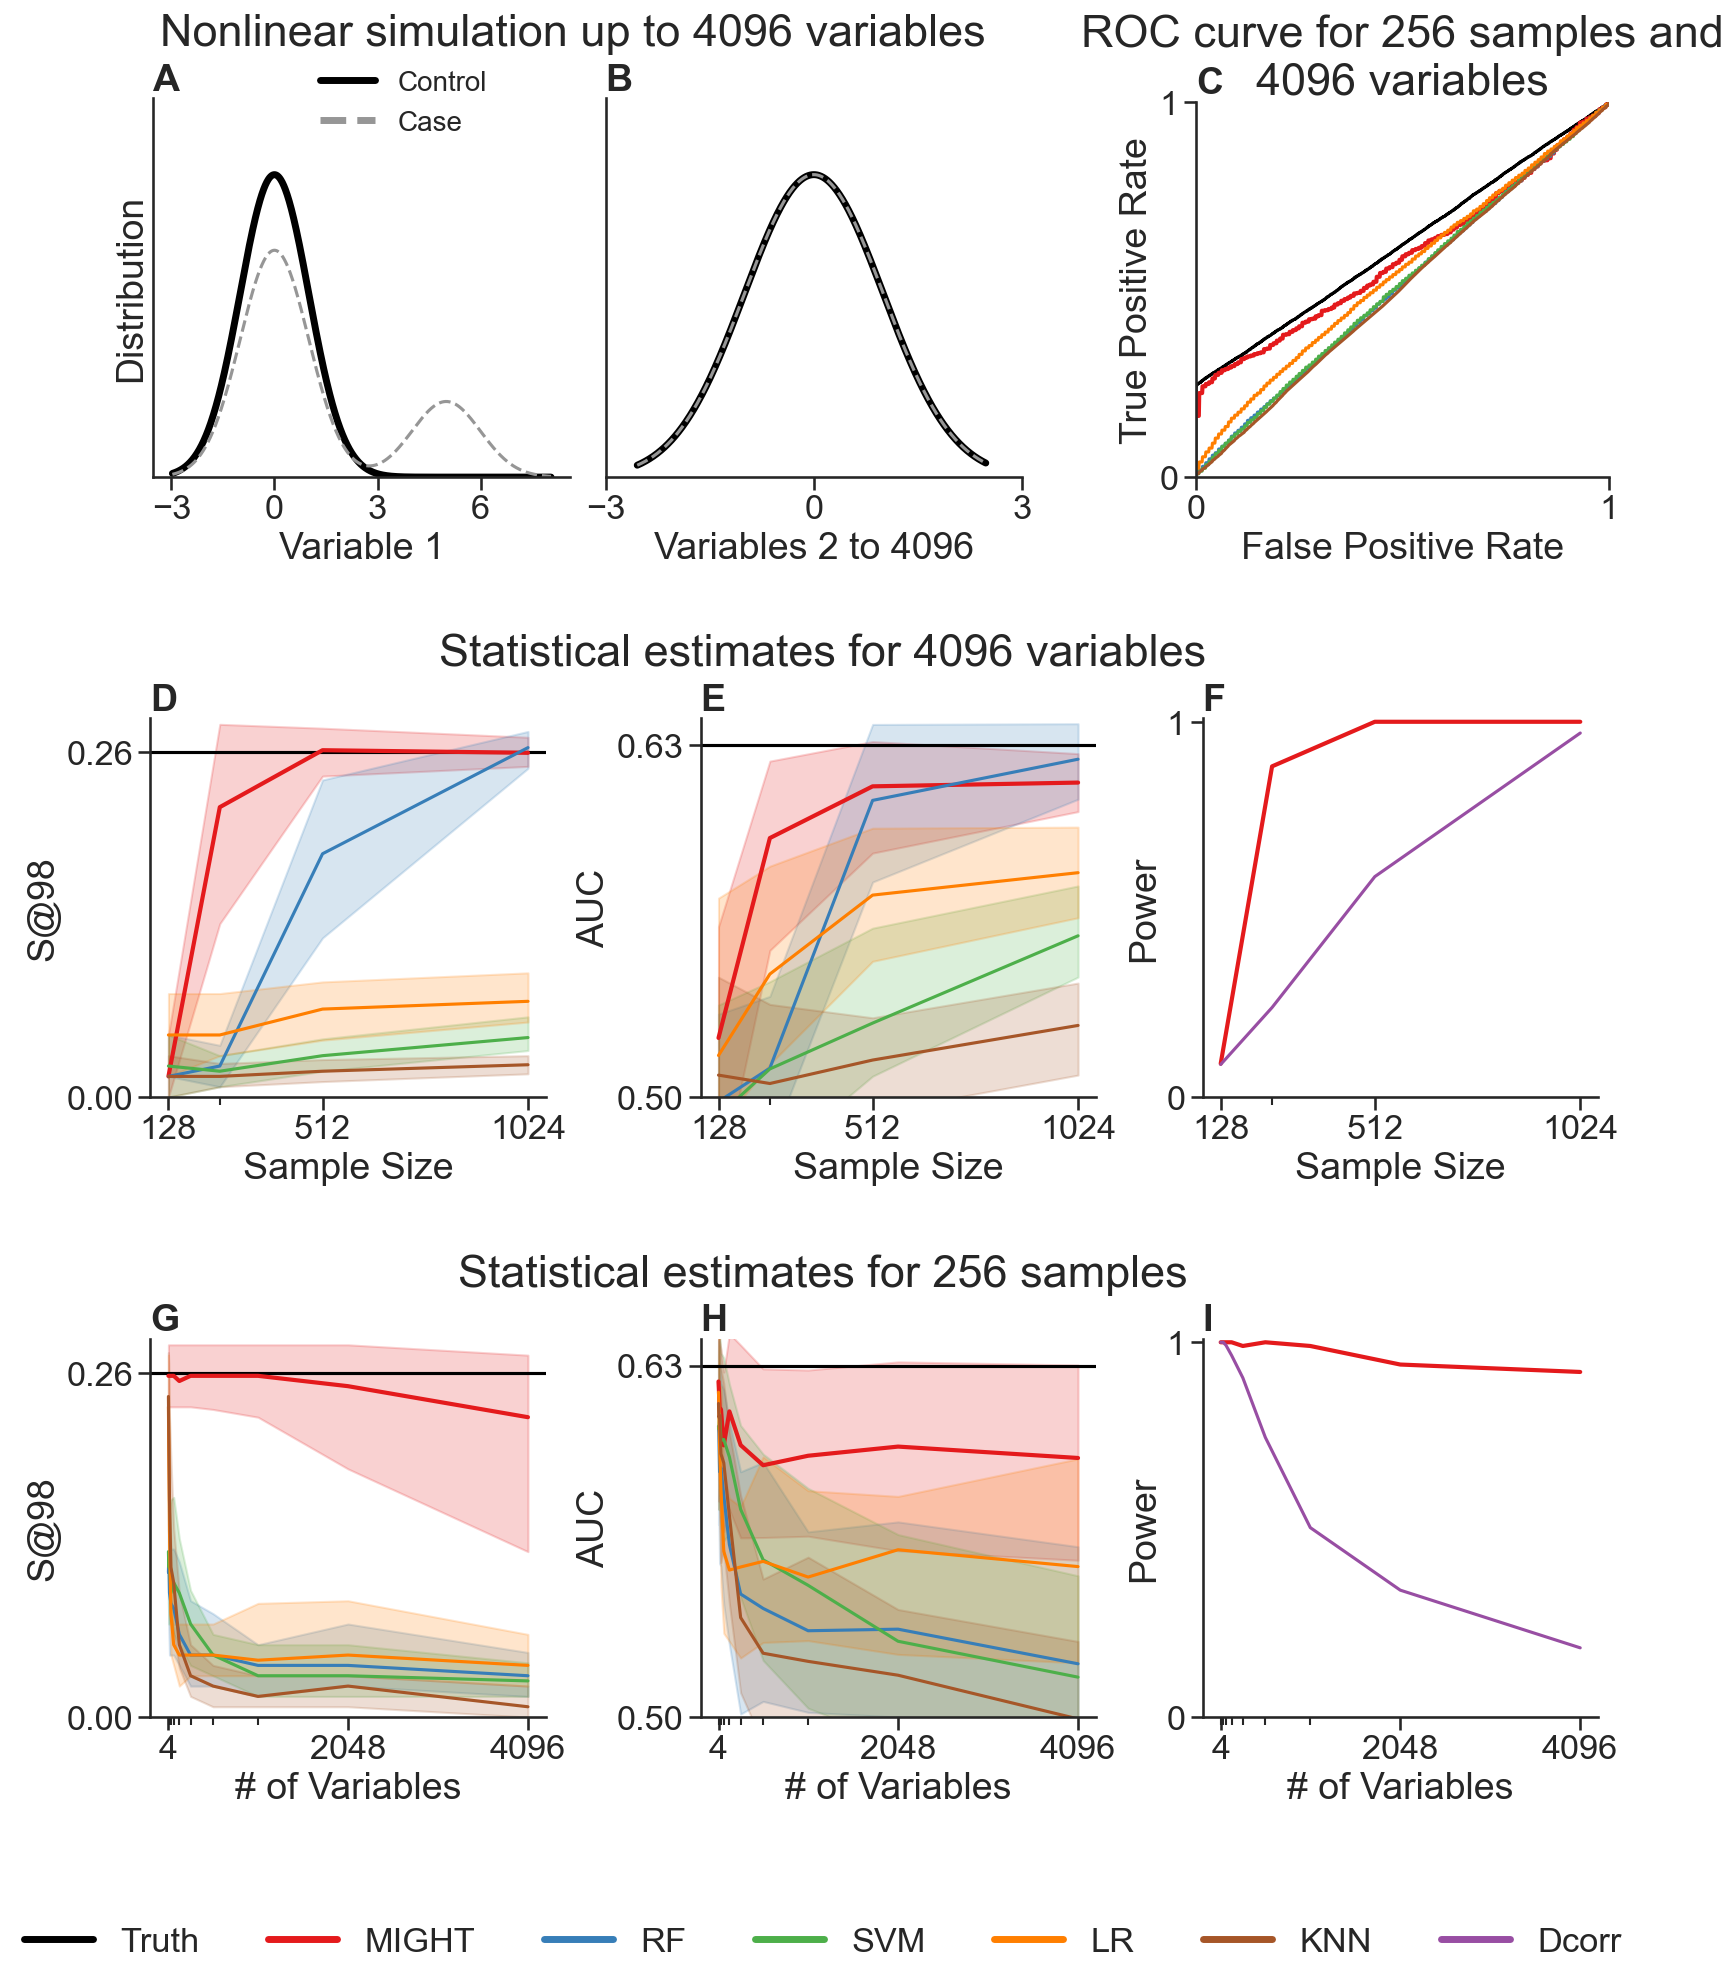

In [57]:
class PlotNonlinearFigure(PlotFigures):
    def __init__(self):
        super().__init__(
            simulation_name="nonlinear",
            simulation_kwargs=dict(split_class1=(0.75, 0.25)),
            truths={
                "S@98" : 0.26,
                "AUC": 0.63,
                "Mutual Information": 0.09,
            },
            simulation_ticks=[-3, 0, 3, 6]
        )

    def __call__(self):
        self.plot_figure()

nonlinear_figure = PlotNonlinearFigure()
nonlinear_figure()

results/linear-RF-power-vs-n.csv is missing
results/linear-SVM-power-vs-n.csv is missing
results/linear-LR-power-vs-n.csv is missing
results/linear-KNN-power-vs-n.csv is missing
results/linear-RF-power-vs-d.csv is missing
results/linear-SVM-power-vs-d.csv is missing
results/linear-LR-power-vs-d.csv is missing
results/linear-KNN-power-vs-d.csv is missing


/var/folders/hv/z6m539f55cnc_sq3pr7whlyh0000gn/T/ipykernel_95877/3410539287.py:48: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  leg_roc = fig.legend(


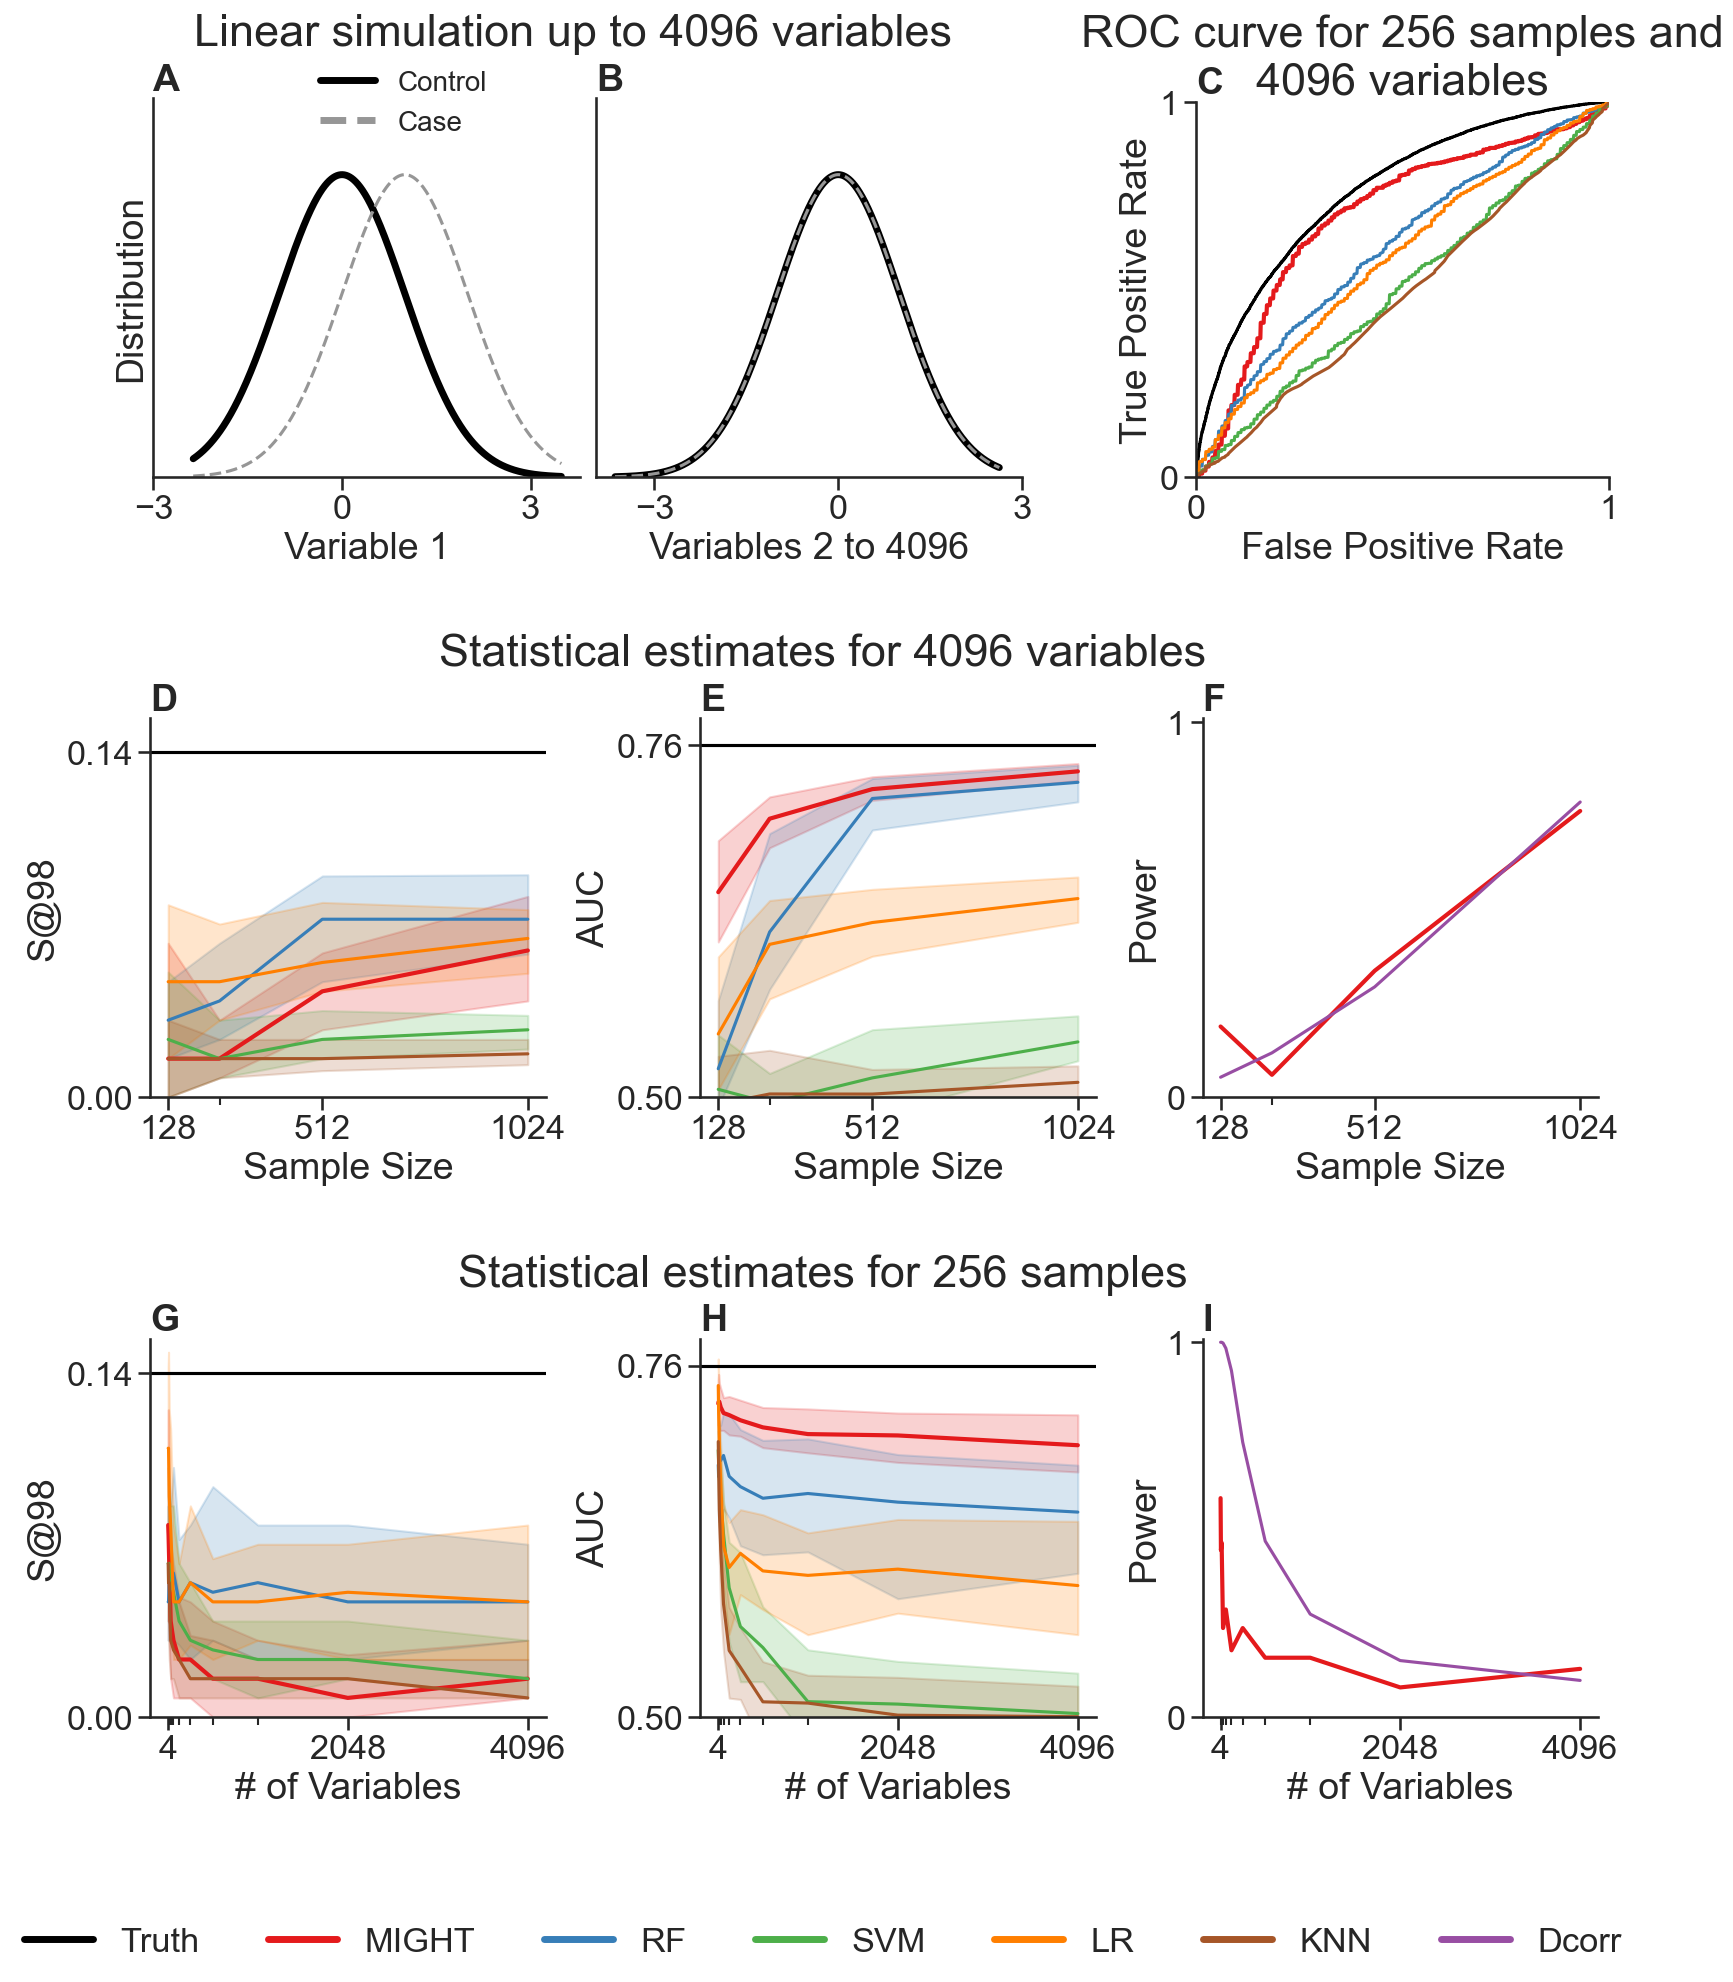

In [38]:
class PlotLinearFigure(PlotFigures):
    def __init__(self):
        super().__init__(
            simulation_name="linear",
            simulation_kwargs={},
            truths={
                "S@98" : 0.14,
                "AUC": 0.76,
                "Mutual Information": 0.11,
            }
        )

    def __call__(self):
        self.plot_figure()

linear_figure = PlotLinearFigure()
linear_figure()

/Users/spanda/workspace/might/gauss_mix.py:42: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  dtype=np.dtype((float, p))
/Users/spanda/workspace/might/gauss_mix.py:58: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  dtype=np.dtype((float, p))
/Users/spanda/workspace/might/gauss_mix.py:42: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  dtype=np.dtype((float, p))
/Users/spanda/workspace/might/gauss_mix.py:58: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  dtype=np.dtype((float, p))


results/independent-RF-power-vs-n.csv is missing
results/independent-SVM-power-vs-n.csv is missing
results/independent-LR-power-vs-n.csv is missing
results/independent-KNN-power-vs-n.csv is missing
results/independent-RF-power-vs-d.csv is missing
results/independent-SVM-power-vs-d.csv is missing
results/independent-LR-power-vs-d.csv is missing
results/independent-KNN-power-vs-d.csv is missing


/var/folders/hv/z6m539f55cnc_sq3pr7whlyh0000gn/T/ipykernel_95877/3410539287.py:48: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  leg_roc = fig.legend(


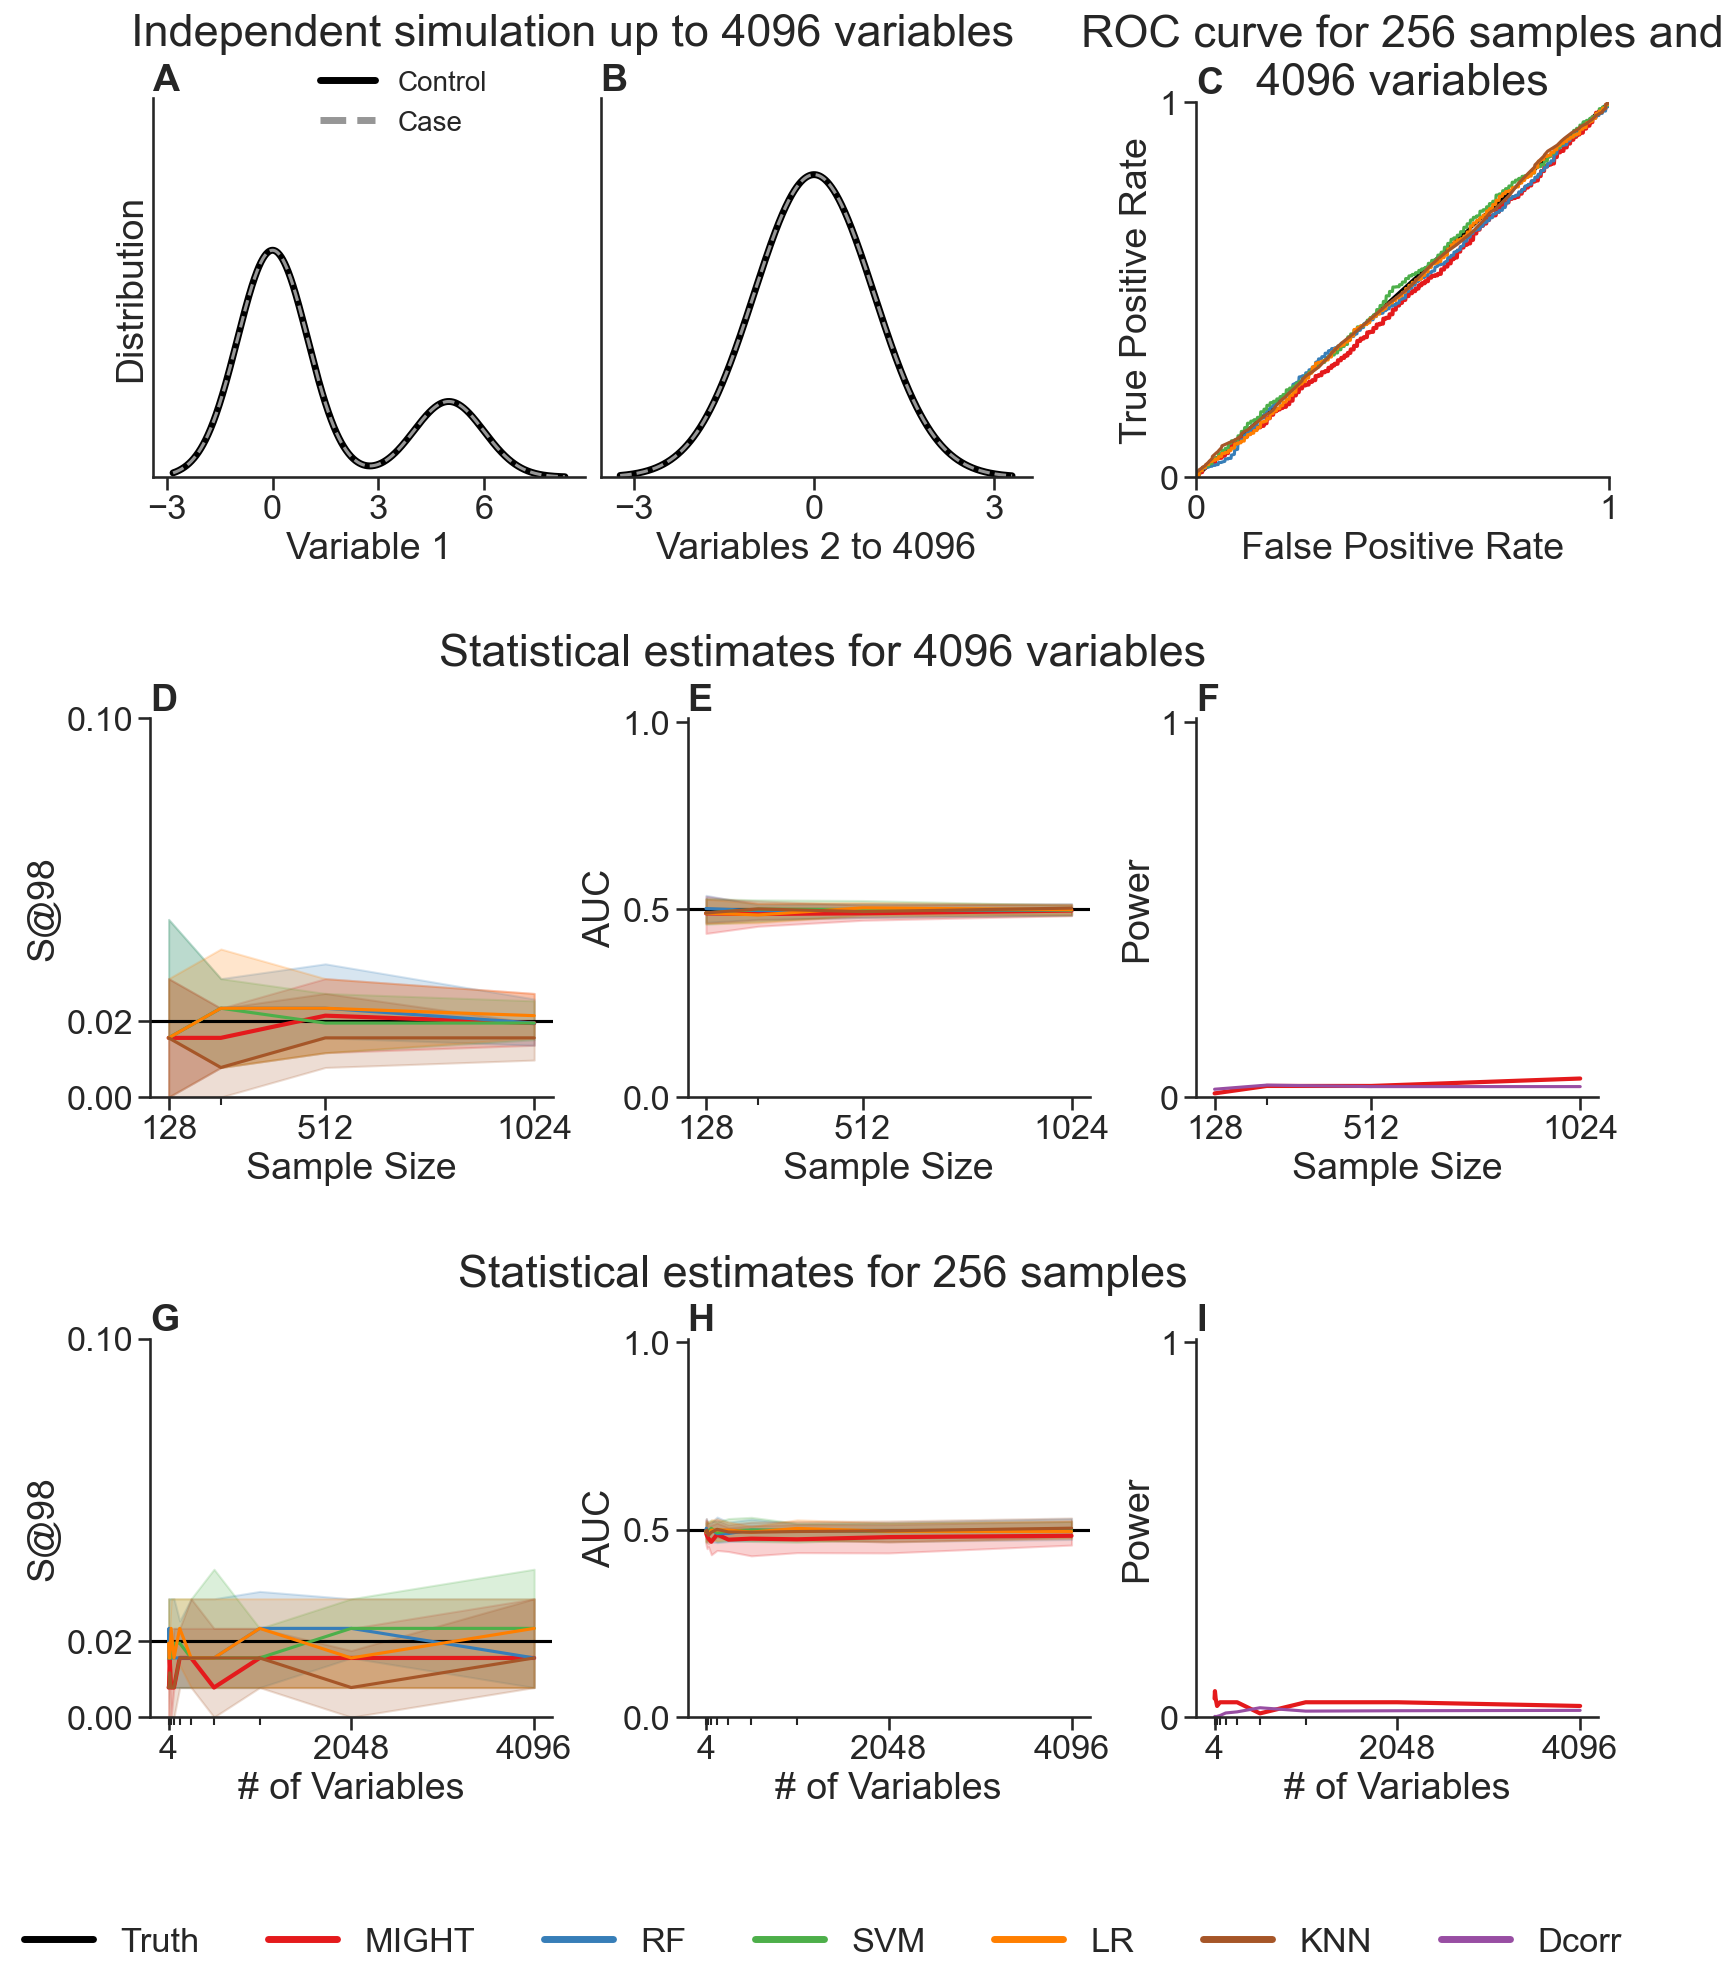

In [39]:
class PlotIndependentFigure(PlotFigures):
    def __init__(self):
        super().__init__(
            simulation_name="independent",
            simulation_kwargs=dict(split_class0=(0.75, 0.25), split_class1=(0.75, 0.25)),
            truths={
                "S@98" : 0.02,
                "AUC": 0.5,
                "Mutual Information": 0,
            },
            simulation_ticks=[-3, 0, 3, 6]
        )

    def __call__(self):
        self.plot_figure()

independent_figure = PlotIndependentFigure()
independent_figure()

In [17]:
CONDITIONAL_COMMON_CLFS = {
    "CoMIGHT" : {"color" : "#e41a1c", "lw" : 3},
    "RF" : {"color" : "#377eb8"},
    "SVM" : {"color" : "#4daf4a"},
    "LR" : {"color" : "#ff7f00"},
    "KNN" : {"color" : "#a65628"},
}

CONDITIONAL_ALL_CLFS = {
    "S@98" : CONDITIONAL_COMMON_CLFS,
    "CMI" : dict(CONDITIONAL_COMMON_CLFS, KSG={"color" : "#f781bf"}),
    "AUC" : CONDITIONAL_COMMON_CLFS,
    "Power" : dict(CONDITIONAL_COMMON_CLFS, Dcorr={"color" : "#984ea3"})
}

CONDITIONAL_FILE_METRICS = {
    "S@98": "sas98",
    "CMI" : "cmi",
    "AUC" : "AUC",
    "Power" : "power"
}

CONDITIONAL_COLUMN_ORDER = [
    "S@98",
    "AUC",
    # "CMI",
    "Power"
]

In [52]:
class PlotConditionalFigures(ABC):
    def __init__(self, simulation_name, simulation_kwargs=None, roc_iterations=100, truths=None, simulation_ticks=[-3, 0, 3]):
        self.simulation_name = simulation_name
        self.simulation_kwargs = simulation_kwargs
        self.roc_iterations = roc_iterations
        self.truths = truths
        self.simulation_ticks = simulation_ticks

    def plot_figure(self):
        # define figure attributes
        fig = plt.figure(figsize=(16, 18), constrained_layout=True)
        self.ncols = 3
        subfigs = fig.subfigures(3, 1, hspace=0.1)
        subfigs_top = subfigs[0].subfigures(1, 2, width_ratios=[2, 1], wspace=0.1)
        subfigs_top_pad = subfigs_top[0].subfigures(1, 2, width_ratios=[1, 13])
        axs_sims = subfigs_top_pad[1].subplots(1, 2)
        axs_roc = subfigs_top[1].subplots(1, 1)
        axs_inc_n = subfigs[1].subplots(1, 3)
        axs_inc_d = subfigs[2].subplots(1, 3)
        self.axes = [*axs_sims, axs_roc, *axs_inc_n, *axs_inc_d]
        
        self.plot_simulations()
        self.plot_roc()
        self.plot_metrics_power()

        # misc section titles
        subfigs_top_pad[1].suptitle(f"{self.simulation_name.capitalize()} simulation with 506 variables in Set 1\nand 6 variables in Set 2")
        subfigs_top[1].suptitle("ROC curve for 512 samples\nand 512 total variables", fontsize='large')
        subfigs[1].suptitle("Statistical estimates for 512 total variables")
        subfigs[2].suptitle("Statistical estimates for 512 samples")

        # add lettering
        for i, ax in enumerate(self.axes):
            ax.set_title(
                string.ascii_uppercase[i], loc="left", weight="bold"
            )
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        # add legends
        leg_sims = fig.legend(
            *self.axes[1].get_legend_handles_labels(),
            loc="upper left",
            ncol=1,
            bbox_to_anchor=(0.17, 0.95),
            fontsize=20,
        )
        leg_roc = fig.legend(
            handles=self.axes[2].get_legend_handles_labels()[0] + [self.axes[5].get_legend_handles_labels()[0][-1]],
            labels=self.axes[2].get_legend_handles_labels()[1] + [self.axes[5].get_legend_handles_labels()[1][-1]],
            *self.axes[2].get_legend_handles_labels(),
            loc="lower center",
            ncol=len(self.axes[2].get_legend_handles_labels()[1]) + 1,
            bbox_to_anchor=(0.5, -0.1),
            # columnspacing=4.0
        )
        # leg_mi = fig.legend(
        #     handles=[self.axes[6].get_legend_handles_labels()[0][-1]],
        #     labels=[self.axes[6].get_legend_handles_labels()[1][-1]],
        #     loc="lower center",
        #     ncol=1,
        #     bbox_to_anchor=(0.741, -0.13)
        # )
        # leg_power = fig.legend(
        #     handles=[self.axes[5].get_legend_handles_labels()[0][-1]],
        #     labels=[self.axes[5].get_legend_handles_labels()[1][-1]],
        #     loc="lower center",
        #     ncol=1,
        #     bbox_to_anchor=(0.873, -0.16)
        # )
        # for leg in [leg_sims, leg_roc, leg_mi, leg_power]:
        for leg in [leg_sims, leg_roc]:
            leg.get_frame().set_linewidth(0)
            for legobj in leg.legend_handles:
                legobj.set_linewidth(5.0)

        plt.show()

    def plot_simulations(self, n=50):
        pdf = self._generate_data(n, **self.simulation_kwargs)[-1]
        pdf_noise = self._generate_data(n, mu_class1=0)[-1]

        for i, plot_pdf in enumerate([pdf, pdf_noise]):
            sns.lineplot(
                plot_pdf, x="x", y="pdf_class0", color="black", ax=self.axes[i], label="Control", legend=False, lw=5
            )
            sns.lineplot(
                plot_pdf, x="x", y="pdf_class1", color="#969696", ax=self.axes[i], label="Case", linestyle="--", legend=False
            )

        # make plot look pretty
        self.axes[0].set(
            xlabel="Set A Variable 1",
            ylabel="Distribution",
            xticks=self.simulation_ticks,
            yticks=[],
            ylim=[0, 0.5]
        )
        self.axes[1].set(
            xlabel="All 511 Other Variables",
            ylabel="",
            xticks=[-3, 0, 3],
            yticks=[],
            ylim=[0, 0.5]
        )

        # simulated_df = pd.DataFrame(dict(x=x.ravel(), x_noise=x_noise.ravel(), hue=np.tile([0, 1], n // 2)))
        # sns.scatterplot(simulated_df, x="x", y="x_noise", hue="hue", ax=self.axes[2], palette=["black", "#969696"], legend=False)

        # # make plot look pretty
        # self.axes[2].set(
        #     xlabel="Variable 1",
        #     ylabel="Other Variables",
        #     xticks=self.simulation_ticks,
        #     yticks=[-3, 0, 3]
        # )

    @staticmethod
    def _generate_data(n=256, **kwargs):
        return generate_gauss_mix(
            N=n,
            **kwargs,
        )

    def plot_roc(self):
        # compute true fpr, tpr, and thresholds and plot the ROC
        x, y, posterior, *_ = self._generate_data(n=50000, **self.simulation_kwargs)
        true_fpr, true_tpr, true_thresholds = roc_curve(
            y, posterior, pos_label=1, drop_intermediate=False
        )
        # self.axes[2].plot([0, 1], [0, 1], linestyle="--", color="black", alpha=0.5),
        self.axes[2].plot(true_fpr, true_tpr, label="Truth", color="black")
        
        # load all other classifier ROC data and plot ROC curves
        base_fpr = np.linspace(0, 1, 1001)
        for clf_name, plot_kwargs in CONDITIONAL_COMMON_CLFS.items():
            if clf_name == "RF" and self.simulation_name != "nonlinear":
                self.axes[2].plot(base_fpr, np.full(base_fpr.shape, np.nan), **plot_kwargs, label=clf_name)
            try:
                with open(f"fig1_v2_results/fpr_{self.simulation_name}_{clf_name}.pkl", "rb") as f:
                    clf_fpr = pickle.load(f)
            except FileNotFoundError:
                print(f"fig1_v2_results/fpr_{self.simulation_name}_{clf_name}.pkl is missing")
                continue
            try:
                with open(f"fig1_v2_results/tpr_{self.simulation_name}_{clf_name}.pkl", "rb") as f:
                    clf_tpr = pickle.load(f)
            except FileNotFoundError:
                print(f"fig1_v2_results/tpr_{simulation_name}_{clf_name}.pkl is missing")
                continue
            clf_tprs = []
            for i in range(self.roc_iterations):
                try:
                    clf_tprs.append(np.interp(base_fpr, clf_fpr[i], clf_tpr[i]))
                except IndexError:
                    break
            # mean_clf_tpr = np.mean(clf_tprs, axis=0)
            mean_clf_tpr = np.full(base_fpr.size, np.nan)
            self.axes[2].plot(base_fpr, mean_clf_tpr, **plot_kwargs, label=clf_name)

        # make plot look pretty
        self.axes[2].set(
            xlabel="False Positive Rate",
            ylabel="True Positive Rate",
            xticks=[0, 1],
            yticks=[0, 1],
            xlim=[0, 1],
            ylim=[0, 1]
        )

    def plot_metrics_power(self):
        for i, ax in enumerate(self.axes[self.ncols:]):
            c = i % self.ncols
            metric = CONDITIONAL_COLUMN_ORDER[c]
            if metric != "Power":
            #     ax.axhline(
            #         y=0.05,
            #         linestyle=":",
            #         color="black",
            #         label="Alpha",
            #     )
            # else:
                ax.axhline(
                    y=self.truths[metric],
                    color="black",
                )

            if i // self.ncols == 0:
                xs = [256, 512, 1024]#, 2048, 4096]
                n_or_d = "n"
            else:
                xs = [2**i for i in range(3, 12)]
                n_or_d = "d"
            for i, (test, plot_kwargs) in enumerate(CONDITIONAL_ALL_CLFS[metric].items()):
                # TODO: Delete
                if test != "CoMIGHT":
                    continue

                file_test = test if test != "CoMIGHT" else test.lower()
                if metric == "Power" and test == "CoMIGHT":
                    file_test += "-sas98"
                try:
                    ys = np.genfromtxt(
                        f"results/conditional/{self.simulation_name}-conditional-{file_test}-{CONDITIONAL_FILE_METRICS[metric]}-vs-{n_or_d}.csv", delimiter=","
                    )
                except FileNotFoundError:
                    print(f"results/conditional/{self.simulation_name}-conditional-{file_test}-{CONDITIONAL_FILE_METRICS[metric]}-vs-{n_or_d}.csv is missing")
                    continue
                if metric == "Power":
                    ys = np.array([y if y > 0 else 0 for y in ys])
                    ax.plot(xs, ys, **plot_kwargs, label=test)
                else:
                    quantiles = []
                    for quantile in [0.25, 0.5, 0.75]:
                        quartile = np.quantile(ys, quantile, axis=1)
                        quartile = np.array([y if y > 0 else 0 for y in quartile])
                        quantiles.append(quartile)
                    ax.plot(xs, quantiles[1], **plot_kwargs, label=test)
                    ax.fill_between(
                        xs,
                        quantiles[0],
                        quantiles[2],
                        alpha=0.2,
                        color=plot_kwargs["color"],
                    )
        
            # make plot pretty
            ax.set(
                # xscale="log" if metric == "Power" and n_or_d == "n" else "linear",
                xlabel = (
                    "Sample Size" if n_or_d == "n"
                    else "# of Variables"
                ),
                ylim=(
                    [0, 1.01] if metric == "Power" or (self.simulation_name == "independent" and metric == "AUC")
                    else [0, 0.1] if self.simulation_name == "independent" and metric != "AUC"
                    else [0.5, (self.truths[metric] - 0.5) / 0.13 * 0.01 + self.truths[metric]] if metric == "AUC"
                    else [0, 1.1 * self.truths[metric]]
                ),
                yticks=(
                    [0, 1] if metric == "Power"
                    else [0, 0.5, 1] if self.simulation_name == "independent" and metric == "AUC"
                    else [0, self.truths[metric], 0.1] if self.simulation_name == "independent"
                    else [0.5, self.truths[metric]] if metric == "AUC"
                    else [0, self.truths[metric]]
                ),
                ylabel=f"{metric}"
            )
            ax.xaxis.set_minor_locator(FixedLocator(xs))
            ax.xaxis.set_major_locator(FixedLocator(
                [256, 512, 1024] if n_or_d == "n"
                else [4, 1024, 2048]
            ))
            # ax.xaxis.set_major_formatter(ScalarFormatter())
            # ax.xaxis.set_minor_formatter(NullFormatter())

/Users/spanda/workspace/might/gauss_mix.py:42: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  dtype=np.dtype((float, p))
/Users/spanda/workspace/might/gauss_mix.py:42: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  dtype=np.dtype((float, p))


fig1_v2_results/fpr_nonlinear_CoMIGHT.pkl is missing
results/conditional/nonlinear-conditional-comight-AUC-vs-n.csv is missing
results/conditional/nonlinear-conditional-comight-AUC-vs-d.csv is missing


/var/folders/hv/z6m539f55cnc_sq3pr7whlyh0000gn/T/ipykernel_95877/525670837.py:48: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  leg_roc = fig.legend(


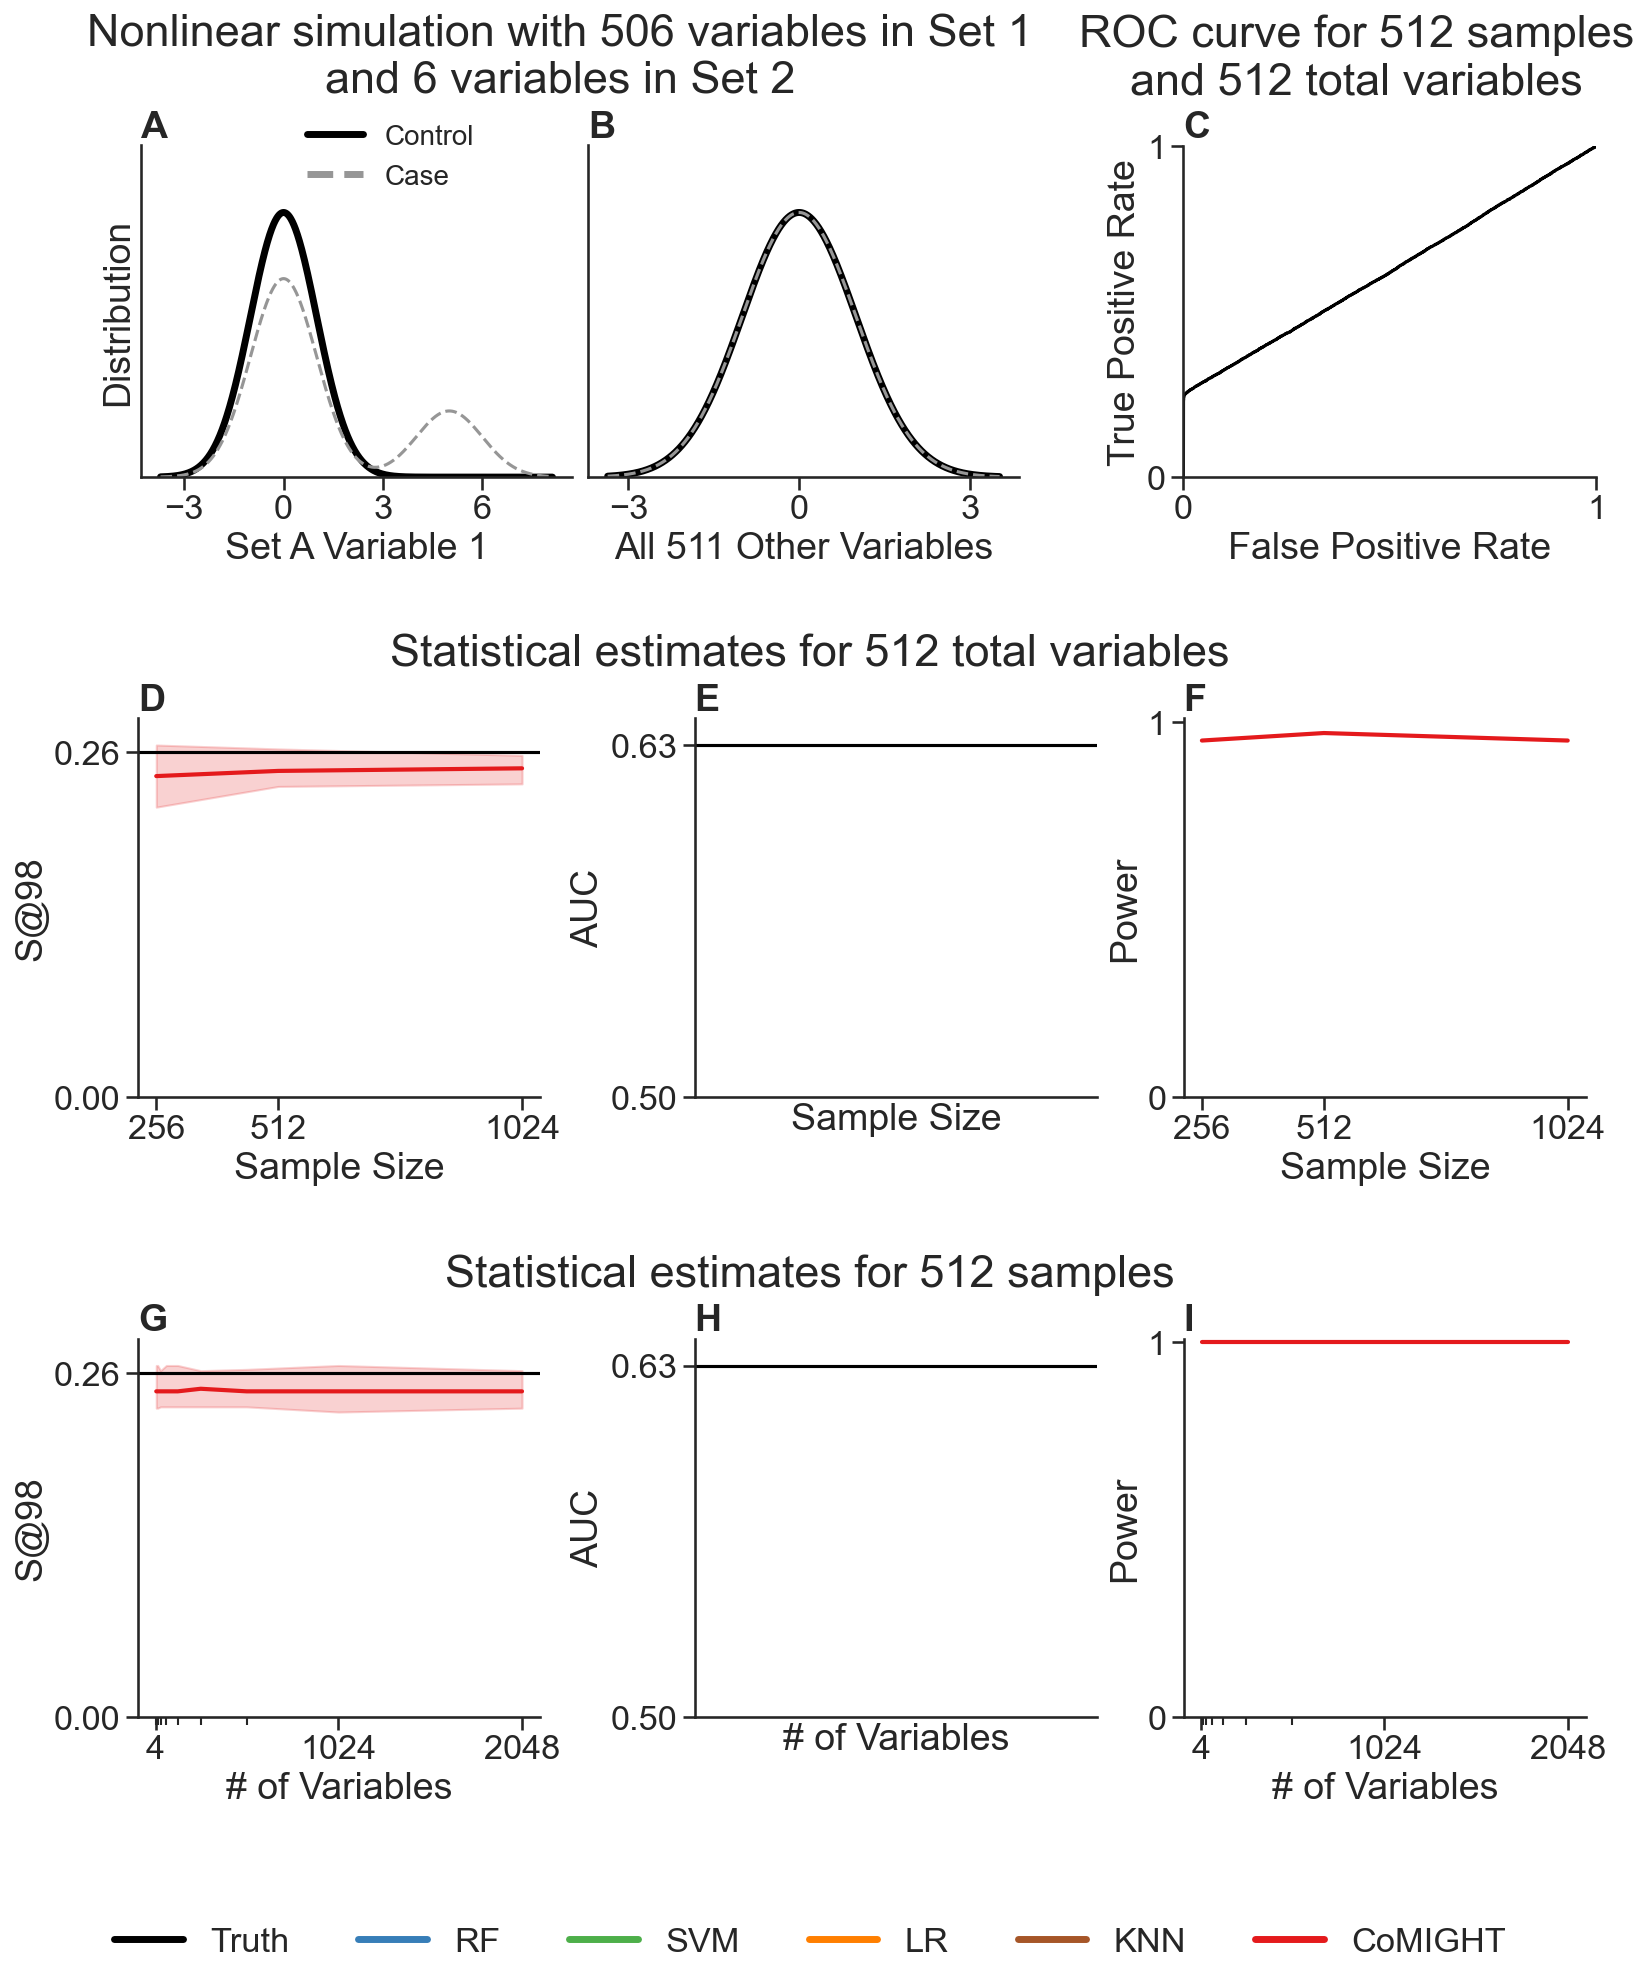

In [53]:
class PlotConditionalNonlinearFigure(PlotConditionalFigures):
    def __init__(self):
        super().__init__(
            simulation_name="nonlinear",
            simulation_kwargs=dict(split_class1=(0.75, 0.25)),
            truths={
                "S@98" : 0.26,
                "AUC": 0.63,
                "Mutual Information": 0.09,
            },
            simulation_ticks=[-3, 0, 3, 6]
        )

    def __call__(self):
        self.plot_figure()

nonlinear_conditional_figure = PlotConditionalNonlinearFigure()
nonlinear_conditional_figure()